In [369]:
import os
import sys
import pyspark as ps
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [370]:

# set up the environment
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# initialize a new spark session
def new_session():
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Pyspark Titanic Survival") \
        .getOrCreate()
    return spark

spark = new_session()

In [371]:
# Load Titanic train dataset
titanic_data = spark.read.csv("D:/Code Space/Datasets/titanic/train.csv", header = True, inferSchema = True)

titanic_data.printSchema()
titanic_data.show(5)

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|   

In [372]:
# Select relevant features for the model
feature_selection = ["Pclass", "Age", "Fare", 'SibSp', "Parch", "Sex", "Embarked"]

# Create a new dataframe with the selected features
feature_cols = ["Pclass", "Age", "Fare", 'SibSp', "Parch", "SexIndex", "EmbarkedIndex"]

# Handle missing values
titanic_data = titanic_data.fillna({"Age": titanic_data.agg({"Age": "mean"}).collect()[0][0]})

In [373]:
# Encoding categorical features
indexers = [StringIndexer(inputCol = col, outputCol = col + "Index").fit(titanic_data).setHandleInvalid("skip") for col in ["Sex", "Embarked"]]

# Create a pipeline object
pipeline = Pipeline(stages = indexers)

# Fit and transform the data
titanic_data = pipeline.fit(titanic_data).transform(titanic_data)

In [374]:
# VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols = feature_cols, outputCol = "features")

# Transform the data
titanic_data = assembler.transform(titanic_data)

In [375]:
# Split the data into training and test sets (20% held out for testing)
(training_data, test_data) = titanic_data.randomSplit([0.8, 0.2], seed=1234)

In [376]:
# Create logistic regression model to predict whether a customer will survive or not
lr = LogisticRegression(featuresCol = "features", labelCol = "Survived")

In [377]:
# Train the model using Logistic Regression and show coefficients and intercepts
from IPython.display import display, Markdown

lr_model = lr.fit(training_data)
coefficients = lr_model.coefficients
intercept = lr_model.intercept

# Creating the formula string
formula = "log(p / (1 - p)) = {:.4f} + {:.4f} * Pclass + {:.4f} * Age + {:.4f} * SibSp + {:.4f} * Parch + {:.4f} * SexIndex + {:.4f} * EmbarkIndex".format(
    intercept, coefficients[0], coefficients[1], coefficients[2], coefficients[3], coefficients[4], coefficients[5], coefficients[6]
)
display(Markdown("Model Formula: $" + formula + "$"))


Model Formula: $log(p / (1 - p)) = 2.1615 + -1.0634 * Pclass + -0.0426 * Age + 0.0030 * SibSp + -0.3351 * Parch + -0.0888 * SexIndex + 2.6528 * EmbarkIndex$

In [378]:
# Make predictions on test data using the Transformer.transform() method
predictions = lr_model.transform(test_data)
table = predictions.select("Survived", "prediction")
predictions = predictions.select("Survived", "probability").rdd.map(lambda row: (float(row["probability"][1]), float(row["Survived"]))) #
y_pred_prob, y_true = zip(*predictions.collect())

In [379]:
# Evaluate the performance of the model
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob) 

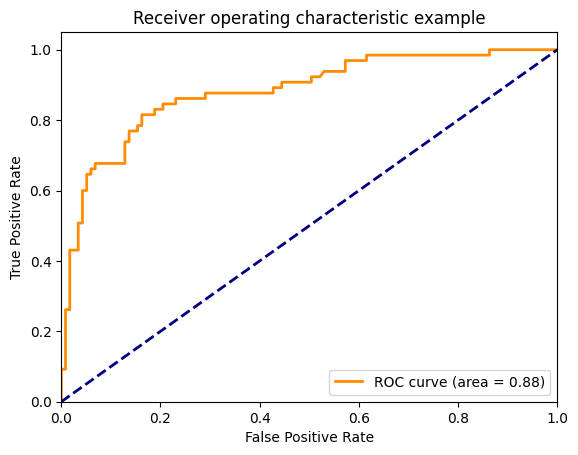

In [380]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc = "lower right")
plt.show()

In [381]:
# End spark session
spark.stop()